In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Input Data (X) - 4 combinations
X_np = np.array([[0,0], [0,1], [1,0], [1,1]], dtype=np.float32)

# 2. Output Data (y) - XOR Logic
y_np = np.array([[0], [1], [1], [0]], dtype=np.float32)

print("Dataset Shapes:", X_np.shape, y_np.shape)

Dataset Shapes: (4, 2) (4, 1)


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# A. Build the MLP
# Hidden layer: 8 neurons, ReLU activation (handles non-linearity)
# Output layer: 1 neuron, Sigmoid activation (outputs probability 0-1)
model_keras = Sequential([
    Dense(8, input_dim=2, activation='relu'),
    Dense(1, activation='sigmoid')
])

# B. Compile
model_keras.compile(loss='binary_crossentropy', 
                    optimizer=Adam(learning_rate=0.1), 
                    metrics=['accuracy'])

# C. Train
print("Training Keras...")
history = model_keras.fit(X_np, y_np, epochs=100, verbose=0)

# D. Evaluate
preds = model_keras.predict(X_np)
print(f"Keras Predictions:\n{preds.round()}")

c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Keras...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Keras Predictions:
[[0.]
 [1.]
 [1.]
 [0.]]


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert numpy data to PyTorch tensors
X_torch = torch.from_numpy(X_np)
y_torch = torch.from_numpy(y_np)

# A. Define the Model Class
class XORModel(nn.Module):
    def __init__(self):
        super(XORModel, self).__init__()
        self.hidden = nn.Linear(2, 8)  # 2 Inputs -> 8 Hidden
        self.output = nn.Linear(8, 1)  # 8 Hidden -> 1 Output
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

model_torch = XORModel()

# B. Loss and Optimizer
criterion = nn.BCELoss() # Binary Cross Entropy
optimizer = optim.Adam(model_torch.parameters(), lr=0.1)

# C. Training Loop
print("\nTraining PyTorch...")
for epoch in range(100):
    optimizer.zero_grad()       # 1. Clear gradients
    outputs = model_torch(X_torch) # 2. Forward pass
    loss = criterion(outputs, y_torch) 
    loss.backward()             # 3. Backward pass (compute gradients)
    optimizer.step()            # 4. Update weights

# D. Evaluate
with torch.no_grad():
    preds = model_torch(X_torch)
    print(f"PyTorch Predictions:\n{preds.round()}")


Training PyTorch...
PyTorch Predictions:
tensor([[0.],
        [1.],
        [1.],
        [0.]])


In [4]:
import tensorflow as tf

# Data setup
X_tf = tf.constant(X_np)
y_tf = tf.constant(y_np)

# A. Define Variables (Weights and Biases) manually
# Xavier/Glorot Initialization is often better, but RandomNormal works for simple XOR
W1 = tf.Variable(tf.random.normal([2, 8], stddev=0.1)) # Weights Input->Hidden
b1 = tf.Variable(tf.zeros([8]))                        # Bias Hidden
W2 = tf.Variable(tf.random.normal([8, 1], stddev=0.1)) # Weights Hidden->Output
b2 = tf.Variable(tf.zeros([1]))                        # Bias Output

optimizer = tf.optimizers.Adam(learning_rate=0.1)

# B. Training Loop using GradientTape
print("\nTraining TF Low-Level...")
for epoch in range(100):
    with tf.GradientTape() as tape:
        # Forward Pass: Manual Matrix Multiplication
        # Layer 1
        z1 = tf.matmul(X_tf, W1) + b1
        a1 = tf.nn.relu(z1) 
        
        # Layer 2 (Output)
        z2 = tf.matmul(a1, W2) + b2
        pred = tf.nn.sigmoid(z2)
        
        # Loss Calculation
        loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_tf, pred))

    # Calculate Gradients
    gradients = tape.gradient(loss, [W1, b1, W2, b2])
    
    # Update Weights
    optimizer.apply_gradients(zip(gradients, [W1, b1, W2, b2]))

# C. Evaluate
def predict_manual(x):
    z1 = tf.matmul(x, W1) + b1
    a1 = tf.nn.relu(z1)
    return tf.nn.sigmoid(tf.matmul(a1, W2) + b2)

preds = predict_manual(X_tf)
print(f"TF Low-Level Predictions:\n{tf.round(preds).numpy()}")


Training TF Low-Level...
TF Low-Level Predictions:
[[0.]
 [1.]
 [1.]
 [0.]]


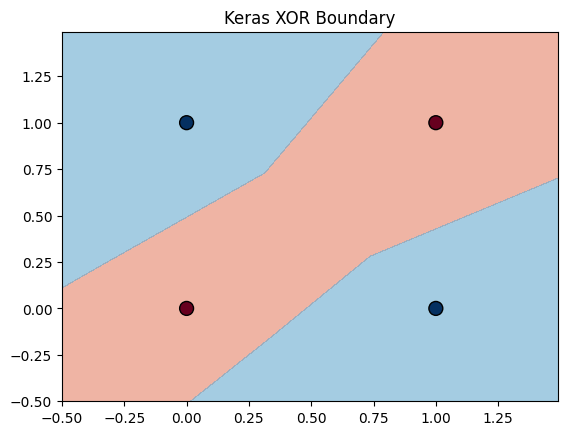

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# ==========================================
# 0. PREPARE DATA
# ==========================================
# XOR Inputs: (0,0), (0,1), (1,0), (1,1)
X = np.array([[0,0], [0,1], [1,0], [1,1]], dtype=np.float32)
# XOR Outputs: 0, 1, 1, 0
y = np.array([[0], [1], [1], [0]], dtype=np.float32)

# Settings
EPOCHS = 200        # How many times to loop over the data
LEARNING_RATE = 0.05 # How fast the model learns

# Dictionary to save our results for the graph later
results = {} 

print("Starting Comparison...\n")

# ==========================================
# 1. KERAS (The Easiest Way)
# ==========================================
print("--- Training Keras ---")
tf.random.set_seed(42)  # consistent results

start_time = time.time()

# Step A: Build the "stack" of layers
model = Sequential([
    Dense(8, input_dim=2, activation='relu'), # Hidden layer
    Dense(1, activation='sigmoid')            # Output layer
])

# Step B: Config the training
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Step C: Train!
history = model.fit(X, y, epochs=EPOCHS, verbose=0)

# Save results
results['Keras'] = history.history['loss']
print(f"Keras finished in {time.time() - start_time:.4f} seconds.")


# ==========================================
# 2. PYTORCH (The Manual Loop Way)
# ==========================================
print("\n--- Training PyTorch ---")
torch.manual_seed(42)

# Convert numpy arrays to PyTorch Tensors (special arrays for GPU/CPU)
X_torch = torch.from_numpy(X)
y_torch = torch.from_numpy(y)

# Step A: Define the Network Blueprint
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.layer1 = nn.Linear(2, 8)  # Input -> Hidden
        self.layer2 = nn.Linear(8, 1)  # Hidden -> Output
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x

model_pt = SimpleNet()
optimizer = optim.Adam(model_pt.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss() # Binary Cross Entropy Loss

start_time = time.time()
losses_pt = []

# Step B: The Training Loop
for epoch in range(EPOCHS):
    optimizer.zero_grad()       # 1. Clear old gradients
    output = model_pt(X_torch)  # 2. Guess the answer
    loss = criterion(output, y_torch) # 3. Check how wrong we are
    loss.backward()             # 4. Calculate corrections (gradients)
    optimizer.step()            # 5. Apply corrections
    
    losses_pt.append(loss.item())

results['PyTorch'] = losses_pt
print(f"PyTorch finished in {time.time() - start_time:.4f} seconds.")


# ==========================================
# 3. TENSORFLOW LOW-LEVEL (The 'Math' Way)
# ==========================================
print("\n--- Training TF Low-Level ---")
tf.random.set_seed(42)

# Step A: Define Weights (W) and Biases (b) manually
# These are the "knobs" the model will turn to learn
W1 = tf.Variable(tf.random.normal([2, 8], seed=42)) 
b1 = tf.Variable(tf.zeros([8]))
W2 = tf.Variable(tf.random.normal([8, 1], seed=42))
b2 = tf.Variable(tf.zeros([1]))

optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)
losses_tf = []

start_time = time.time()

# Step B: The Loop
for epoch in range(EPOCHS):
    # 'GradientTape' records all operations so we can calculate gradients later
    with tf.GradientTape() as tape:
        # Manual Math: (X * W1 + b1) -> ReLU -> (.. * W2 + b2) -> Sigmoid
        z1 = tf.matmul(X, W1) + b1
        a1 = tf.nn.relu(z1)
        z2 = tf.matmul(a1, W2) + b2
        pred = tf.nn.sigmoid(z2)
        
        # Calculate Error
        loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y, pred))

    # Calculate Gradients (corrections)
    gradients = tape.gradient(loss, [W1, b1, W2, b2])
    
    # Apply Gradients
    optimizer.apply_gradients(zip(gradients, [W1, b1, W2, b2]))
    
    losses_tf.append(loss.numpy())

results['TF Low-Level'] = losses_tf
print(f"TF Low-Level finished in {time.time() - start_time:.4f} seconds.")


# ==========================================
# 4. VISUALIZE RESULTS
# ==========================================
plt.figure(figsize=(10, 5))
plt.plot(results['Keras'], label='Keras (High-Level)', linewidth=2)
plt.plot(results['PyTorch'], label='PyTorch', linestyle='--')
plt.plot(results['TF Low-Level'], label='TF Low-Level', linestyle=':')

plt.title('Who Learned Faster? (Loss over Epochs)')
plt.xlabel('Epochs (Training Steps)')
plt.ylabel('Loss (Error)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()